In [22]:
import pandas as pd
pd.set_option("display.max_rows", 5)

# Key features

<div style="width: 500px;">
    
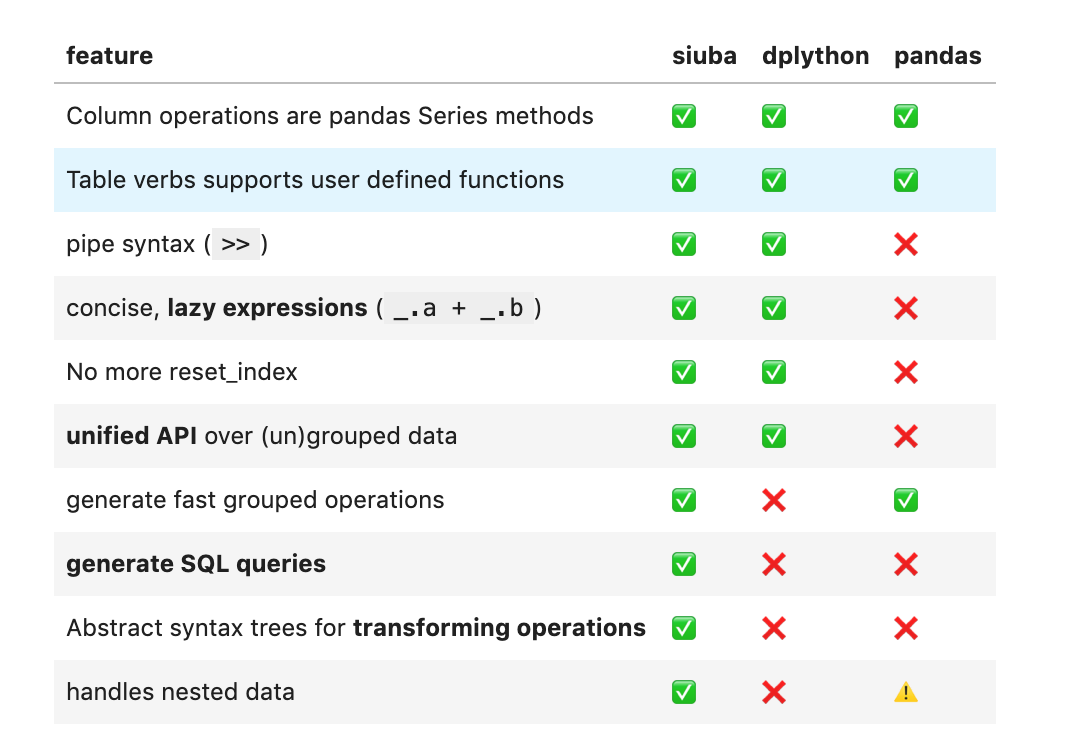
    
</div>

## Built on pandas

pandas is everywhere in python data analysis. The siuba library builds on this momentum by using pandas Series methods as its reference implementation. This means that you use the pandas methods you've already learned!

You are not restricted only existing siuba functions, though. You can add your own functions, and apply the behavior to pandas, SQL, and more.


In [107]:
import pandas as pd
from siuba import _, mutate

df = pd.DataFrame({'a': [1,2,3]})

# pandas: functional approach
df.assign(b = lambda d: d.a.mean())

# siuba
mutate(df, b = _.a.mean())

,a,b
0,1,2.0
1,2,2.0
2,3,2.0


Note how you can debug both pieces of code by running and inspecting `df.a.mean()`.

While pandas is an incredibly powerful API, its syntax can get quite cumbersome.

In [74]:
(df
  .assign(b = lambda d: d.a.mean())    # create new column
  .loc[lambda d: d.a != 3]             # filter out some rows
)

,a,b
0,1,2.0
1,2,2.0


Notice how much of this code is writing the word lambda, and it only works on ungrouped data.

## Inspired by dplython

Like it's predecessor, dplython, siuba offers a more natural way to express and extend data science workflows.

### Pipe syntax

The pipe syntax allows you to import table verbs, rather than having 300+ methods on your DataFrame.

```python
# actions are imported, rather than having 300+ methods on your data --- 
from siuba import mutate

# this means you can package actions yourself --- 
from my_awesome_package import some_action
```

### Lazy expressions

Using lazy expressions saves you from repeating the name of your DataFrame over and over.

In [75]:
# rather than repeat the name of your data, you can use lazy expressions ---
my_data_frame = pd.DataFrame({'a': [1,2,3]})


# bad
my_data_frame["b"] = my_data_frame["a"] + 1
my_data_frame["c"] = my_data_frame["b"] + 2

# good
my_data_frame >> mutate(b = _.a + 1, c = _.b + 2)

,a,b,c
0,1,2,4
1,2,3,5
2,3,4,6


Combined, piping and lazy expressions can easily be made re-usable.

In [79]:
# dead simple to make your pipe re-usable ----
f_pipe = mutate(b = _.a + 1) >> mutate(c = _.b + 2)

# either call the pipe on data
f_pipe(my_data_frame)

# or compose it as part of a new pipe
my_data_frame >> f_pipe


,a,b,c
0,1,2,4
1,2,3,5
2,3,4,6


### No reset_index

Notice how siuba mutate can take a DataFrame, and return a DataFrame.
Moreover, it doesn't stick columns onto the index.
This means you don't need to call `reset_index` all the time.

A common place where `reset_index` is called is after a pandas grouped aggregation.

In [19]:
from siuba.data import mtcars
from siuba import summarize

g_cyl = mtcars.groupby("cyl")

agg_res = g_cyl[["hp", "mpg"]].agg("mean")
agg_res

,hp,mpg
cyl,,
4,82.636364,26.663636
6,122.285714,19.742857
8,209.214286,15.100000


In [88]:
# bad
agg_res.reset_index()

,cyl,hp,mpg
0,4,82.636364,26.663636
1,6,122.285714,19.742857
2,8,209.214286,15.100000


In [80]:
# good
summarize(g_cyl, hp = _.hp.mean(), mpg = _.mpg.mean())

,cyl,hp,mpg
0,4,82.636364,26.663636
1,6,122.285714,19.742857
2,8,209.214286,15.100000


### Unified (un)grouped API

In **siuba it doesn't matter** whether your data is grouped or not.

In [86]:
g_cyl = mtcars.groupby("cyl")

mtcars >> mutate(demeaned = _.hp - _.hp.mean())    # uses ungrouped mean
g_cyl  >> mutate(demeaned = _.hp - _.hp.mean())    # uses grouped mean

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,demeaned
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,-12.285714
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,-12.285714
...,...,...,...,...,...,...,...,...,...,...,...,...
30,15.0,8,301.0,335,3.54,3.570,14.60,0,1,5,8,125.785714
31,21.4,4,121.0,109,4.11,2.780,18.60,1,1,4,2,26.363636


In **pandas you have to change your code** for grouped data.

In [103]:
g_cyl = mtcars.groupby("cyl")

# ungrouped vs grouped mean
mtcars.assign(demeaned = lambda d: d.hp - d.hp.mean())
mtcars.assign(demeaned = g_cyl.obj.hp - g_cyl.hp.transform("mean"))

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,demeaned
0,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,-12.285714
1,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,-12.285714
...,...,...,...,...,...,...,...,...,...,...,...,...
30,15.0,8,301.0,335,3.54,3.570,14.60,0,1,5,8,125.785714
31,21.4,4,121.0,109,4.11,2.780,18.60,1,1,4,2,26.363636


Note that `g_cyl` does not have an `assign` method, and requires passing what operation you want to do (`"mean"`) as a string to `.transform()`.

## Going beyond

So far we've covered features of siuba that overlap with other libraries:

* re-use your existing knowledge of pandas Series methods
* take advantage of the dplyr grammar, inspired by dplython's early work

This section will cover features that set siuba apart:

* fast grouped operations
* generating SQL queries
* ASTs
* nested data

### Fast grouped operations

Consider some data (`students`) where 2,000 students have each completed 10 courses, and received a score on each course.

In [91]:
# fast grouped operations (pull from dev docs)
# PLOT of timing
import numpy as np
import pandas as pd
from siuba.experimental.pd_groups import fast_filter

np.random.seed(123)
students = pd.DataFrame({
    'student_id': np.repeat(np.arange(2000), 10),
    'course_id': np.random.randint(1, 20, 20000),
    'score': np.random.randint(1, 100, 20000)
})

,student_id,course_id,score
0,0,14,38
1,0,3,40
...,...,...,...
19998,1999,11,32
19999,1999,17,10


In [99]:
g_students = students.groupby('student_id')
g_students

,student_id,course_id,score
0,0,14,38
1,0,3,40
...,...,...,...
19998,1999,11,32
19999,1999,17,10


Suppose that we want to get the courses each student scored lowest on.

In pandas we could use some complex, but fast code.

In [92]:
%%time
# pandas
is_student_min = g_students.obj.score == g_students.score.transform('min')
low_scores = students[is_student_min]


CPU times: user 7.17 ms, sys: 2.64 ms, total: 9.8 ms
Wall time: 9.8 ms


In siuba it is quite a bit simpler, and comparable in speed.

In [93]:
%%time
# siuba
low_scores = fast_filter(g_students, _.score == _.score.min())

CPU times: user 8.82 ms, sys: 3.69 ms, total: 12.5 ms
Wall time: 10.8 ms


This is because siuba's lazy expressions let it optimize grouped operations.

However, **dplython is over 100x slower** in this case, because it uses the slower pandas `DataFrame.apply()` method under the hood.

In [101]:
# set up code for timing
from dplython import X, DplyFrame, sift, group_by as dply_group_by

g_students2 = DplyFrame(students) >> dply_group_by(X.student_id)

In [100]:
%%time
g_students2 >> sift(X.score == X.score.min())

CPU times: user 1.99 s, sys: 19.1 ms, total: 2.01 s
Wall time: 2.73 s


,student_id,course_id,score
2,0,3,17
10,1,10,1
...,...,...,...
19987,1998,17,31
19997,1999,3,1


### SQL queries

In [33]:
# generate SQL queries
from siuba.data import cars_sql
from siuba import group_by, mutate, show_query

q = (cars_sql
  >> group_by("cyl")
  >> mutate(demeaned = _.hp - _.hp.mean())
  >> show_query()
)


SELECT cars.cyl, cars.mpg, cars.hp, cars.hp - avg(cars.hp) OVER (PARTITION BY cars.cyl) AS demeaned 
FROM cars


### Abstract syntax trees

This is made possible because siuba represents lazy expressions with abstract syntax trees.
Fast grouped operations and SQL queries are just the beginning. This allows people to produce a whole range of interesting tools!


In [ ]:
# ASTs for transforming
# show dplython 

# show that siuba is inspectable

### Nested data

In [34]:
# handles nested data (separate_rows example)